## Prerequisites

In [1]:
# import Qiskit
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *

# import api token
apitoken = 'apitoken = 'paste your api token here'
try :
    IBMQ.enable_account(token=apitoken)
except:
    pass
provider = IBMQ.get_provider(project='default') 

# Noise Model

 In this notebook, we are going to deal with a noisy quantum computer via simulator, to demo a case we may encounter when running an experiment on a real quantum computer.
 The noise sources can be complicated, but result in errors in measurement outcomes. Before eliminating the errors, we need to build up a noise model first.
 
 Note the model is generated for IBM hardwares, for which may not be useful on other physical layouts.
 
Below we introduce some simple errors:

 







### Types of errors

1. `pauli_error(noise_ops)`: Generates a mixed Pauli error. For example,
```python
pauli_error([('X',p), ('I', 1 - p)])
```
returns a Pauli error which randomly flip qubit with propability $p$. Parameter `noise_ops` in `pauli_error(noise_ops)` is a list of pairs `[pair[Pauli(j), p(j)]]` where sum of all probabilities $p(j)$ is unity.

2. `depolarizing_error(p, number_qubits)`: The channel is defined as
$$
E_\text{depolarize}(\rho)
=
(1-p) \rho
+
p \text{Tr}(\rho)
\dfrac{\mathbb{I}}{2^n}.
$$
with depolarizing error $p$ and the number of qubits for the error channel $n$. 
Roughly speaking, with propabilities $p$, the state remains in the same state. Otherwise, the state becomes totally mixed state.

3. `thermal_relaxation_error(t1, t2, time, excited_state_population=0)`: This function gives a single-qubit thermal relaxation error. The four parameters are
 - `t1`: The $T_1$ relaxation time (energy relaxation).
 - `t2`: The $T_2$ relaxation time (phase decoherence). In general, $T_2 \leq T_1$.
 - `time`: The gate time $T_g$ for relaxation error.
 - `excited_state_population`: The population of $\left|1\right>$ at quilibrium. The default setting is `0` meaning that the qubit will eventually loss the information.

### Add errors to noise model

Now we know how to construct quantum errors, but how to apply them to specific qubit? One may want to add the noise to (1)all qubits or (2)specific qubit.
1. `add_all_qubit_quantum_error(error, instructions)`: Apply `error` to `instructions` for all qubits.

2. `add_quantum_error(error, instructions, qubits)`: Add `error` to `instructions` on a list of `qubits`.

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import thermal_relaxation_error, depolarizing_error

noise_model = NoiseModel()

# thermal relaxation error
t1 = 11
t2 = 11
time = 20
thermal_error = thermal_relaxation_error(t1, t2, time)
noise_model.add_all_qubit_quantum_error(thermal_error, ['u1', 'u2', 'u3', 'id'])
print(noise_model)

# depolarizing error
p_depolar = 0.01
depolar_error = depolarizing_error(p_depolar, 1)
noise_model.add_quantum_error(depolar_error, ['measure'], [0])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3', 'id']
  All-qubits errors: ['u1', 'u2', 'u3', 'id']
NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'id', 'u3', 'measure', 'u2']
  Qubits with noise: [0]
  All-qubits errors: ['u1', 'u2', 'u3', 'id']
  Specific qubit errors: [('measure', [0])]


### Combine errors

We may need to combine different errors no matter on the same qubit or different subsystems.
1. Combine errors on different qubits
By tensor product, we can combine the errors. For example,
```python
combine_error = error1.tensor(error2)
```
Here we demo a two-qubit system with different types of error acting on each qubits.

In [3]:
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import pauli_error
p_X = 0.05
p_Z = 0.03
bit_flip = pauli_error([('X', p_X), ('I', 1 - p_X)])
phase_flip = pauli_error([('Z', p_Z), ('I', 1 - p_Z)])

error_combine = bit_flip.tensor(phase_flip) # bit-flip error on q0, phase-flip error on q1
print(error_combine)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0015, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(1) = 0.0485, QasmQobjInstructions = [[{'name': 'x', 'qubits': [1]}]
  P(2) = 0.028499999999999998, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9215, QasmQobjInstructions = [[{'name': 'id', 'qubits': [1]}]


2. For a qubit with more than one types of error, we can use the `compose` command as
```python
combine_error = error1.compose(error2)
```
For instance, if we want to simulate a qubit with both phase-flip and bit-flip errors, the following cell helps:

In [4]:
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0015, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0485, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.028499999999999998, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9215, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


For more noise model, please visit [Qiskit Documentation](https://qiskit.org/documentation/apidoc/aer_noise.html?highlight=depolarizing_error).
We briefly introduce the basic uses of the noise model with Qiskit below. The quantum circuit used in demonstration is the three-qubit GHZ-state generator.

In [17]:
import numpy as np

# build up circuit
n = 3
GHZ_circuit = QuantumCircuit(n, n)
GHZ_circuit.h(0)
for i in range(0, n-1):
    GHZ_circuit.cx(i, i+1)
GHZ_circuit.measure(range(n), range(n))

# add errors
noise_model = NoiseModel()

p_cx = 0.07
error_cx = depolarizing_error(p_cx, 1)
error_cx = error_cx.tensor(error_cx)
noise_model.add_quantum_error(error_cx, ['cx'], [1,2])

t1 = 11
t2 = 11
time = 15
excited_state_population = 0.05
error_thermal = thermal_relaxation_error(t1, t2, time, excited_state_population)
noise_model.add_all_qubit_quantum_error(error_thermal, ['u1', 'u2', 'u3'])

p_flip = 0.12
error_meas_flip = pauli_error([('X', p_flip), ('I', 1 - p_flip)])
noise_model.add_all_qubit_quantum_error(error_meas_flip, ['measure'])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cx', 'u3', 'measure', 'u2']
  Qubits with noise: [1, 2]
  All-qubits errors: ['u1', 'u2', 'u3', 'measure']
  Specific qubit errors: [('cx', [1, 2])]


## Result of a noisy simulator

In [12]:
# Run the noisy simulation
shots = 1024
backend = Aer.get_backend('qasm_simulator')
job_noisy = execute(GHZ_circuit, backend, shots=shots, noise_model=noise_model)
counts_noisy = job_noisy.result().get_counts()

# Plot noisy output
from qiskit.visualization import plot_histogram
print(counts_noisy)
#plot_histogram(counts_noisy)

{'111': 333, '000': 333, '010': 69, '100': 59, '110': 51, '011': 66, '001': 53, '101': 60}


## Result of a ideal simulator

In [13]:
job_ideal = execute(GHZ_circuit, backend, shots=shots)
counts_ideal = job_ideal.result().get_counts()

print(counts_ideal)
#plot_histogram(counts_ideal)

{'111': 495, '000': 529}


## Experiment on a real device

In [14]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                       not x.configuration().simulator and x.status().operational==True))
print('backend: ', backend)
job_qc = execute(GHZ_circuit, backend, shots=shots, optimization_level=3)
counts_qc = job_qc.result().get_counts(GHZ_circuit)

print(counts_qc)
#plot_histogram(counts_qc)

backend:  ibmq_almaden
{'111': 374, '000': 503, '010': 6, '100': 17, '110': 57, '011': 29, '001': 8, '101': 30}


## Comparison

After the effort above, we can now compare the measurement outcomes of the three cases.

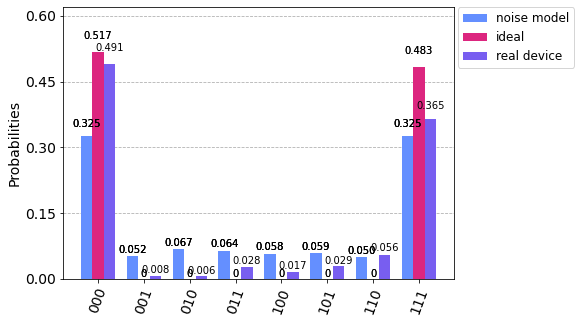

In [15]:
from qiskit.visualization import plot_histogram
plot_histogram([counts_noisy, counts_ideal, counts_qc], legend=['noise model', 'ideal', 'real device'])

***Question:***
**How to get much closer to the reality?**

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

# Exercise: Toffoli Gate

The operation rule for Toffoli gate is actually a generalization to CNOT gate. The first two qubits are the *controlled* qubits while the last acts as the *target*. The target flips only when two *controls* both have value `1`. That is, only when the qubit string is `110` or `111`, the output is different from the input as `111` and `110`, respectively. Otherwise, the input and output are the same.


For simplicity, we first create an oracle, the function `initial_state` in order to initialize the states of qubits. 
Here the initial state is 
$$
\left|\psi_0\right>
=
\left|1\right>
\otimes
\dfrac{1}{\sqrt{2}}
\left( \left|0\right> + \left|1\right> \right)
\otimes
\dfrac{1}{\sqrt{2}}
\left( \left|0\right> + \left|1\right> \right) 
=
\dfrac{1}{2}
\left(
\left|100\right> + \left|101\right> + \left|110\right> + \left|111\right>
\right),
$$
which can be implemented by a NOT gate and two Hadamard gates.

In [68]:
def initial_state(n):
    init_circ = QuantumCircuit(n)
    
    init_circ.x(0)
    init_circ.h(1)
    init_circ.h(2)
    
    init_gate = init_circ.to_gate()
    init_gate.name = 'initial_state'
    return init_gate

In Qiskit, we can insert a Toffoli gate by a simple command `ccx` just as show in below cell.

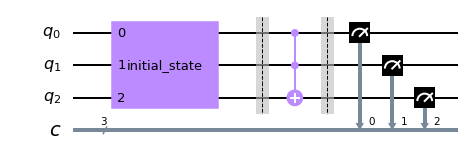

In [69]:
n = 3
ccx_circ = QuantumCircuit(n,n)
# append the oracle 'initial_state' to the circuit
ccx_circ.append(initial_state(n), range(n))
ccx_circ.barrier()
# Toffoli gate with 'ccx' command
ccx_circ.ccx(0,1,2)
ccx_circ.barrier()
ccx_circ.measure(range(n), range(n))
ccx_circ.draw('mpl', scale=0.5)

Or, we can generate the identicle operation with combination of some single-qubit gate a CNOT gate as following.
The proof of the equevelance of these two given circuits is left to you. The measurement outcomes of the two are shown below, please check the matrix representations by yourself.

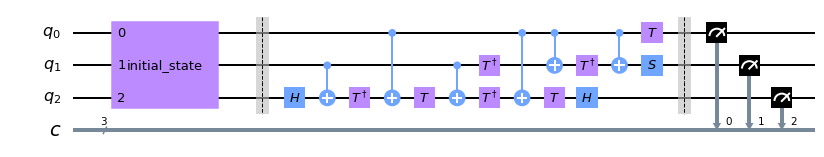

In [70]:
Toffoli_circ = QuantumCircuit(n,n)
Toffoli_circ.append(initial_state(n), range(n))
Toffoli_circ.barrier()
# Toffoli circuit 
Toffoli_circ.h(2)
Toffoli_circ.cx(1,2)
Toffoli_circ.tdg(2)
Toffoli_circ.cx(0,2)
Toffoli_circ.t(2)
Toffoli_circ.cx(1,2)
Toffoli_circ.tdg(2)
Toffoli_circ.cx(0,2)
Toffoli_circ.t(2)
Toffoli_circ.tdg(1)
Toffoli_circ.h(2)
Toffoli_circ.cx(0,1)
Toffoli_circ.tdg(1)
Toffoli_circ.cx(0,1)
Toffoli_circ.s(1)
Toffoli_circ.t(0)
Toffoli_circ.barrier()

Toffoli_circ.measure(range(n), range(n))
Toffoli_circ.draw('mpl',scale=0.5)

Now we introduce somquantum errors into the both circuits, and compare the measurement results to see if there is any difference.
First of all, we run the circuits on the simulator.


ccx=  {'011': 252, '111': 264, '001': 255, '101': 253}
circuit=  {'011': 254, '111': 248, '001': 256, '101': 266}


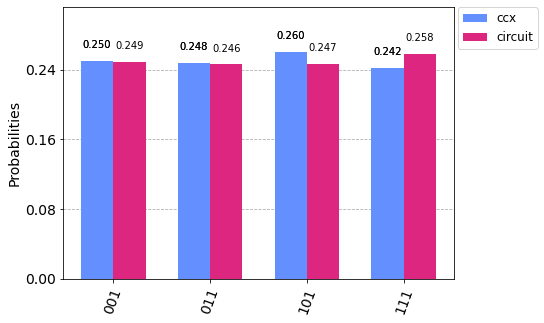

In [71]:
shots = 1024
simulator = Aer.get_backend('qasm_simulator')

job_ccx = execute(ccx_circ, backend=simulator, shots=shots)
counts_ccx = job_ccx.result().get_counts(ccx_circ)
job_Toffoli = execute(Toffoli_circ, backend=simulator, shots=shots)
counts_Toffoli = job_Toffoli.result().get_counts(Toffoli_circ)

print('ccx= ', counts_ccx)
print('circuit= ', counts_Toffoli)
plot_histogram([counts_Toffoli, counts_ccx], legend=['ccx', 'circuit'])

From statistical results, we can say that the two circuits might have identicle operation. 

**Now it your turn to add quantum errors to the circuits.**
Please run the circuits on both  noisy simulator and a real device. Compare the outcomes, which circuits is closer to a real quantum computer? 
Please also transpile the second circuit to the chosen backend and use the resultant circuit as a basis of noise model and do the analysis.